# Character-level Language Modeling with RNN

Adapted from [Practical Pytorch](https://github.com/spro/practical-pytorch/tree/master/char-rnn-generation) and [Character_Level_Language_Model](https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/06_deep_nlp/Character_Level_Language_Model.ipynb)

Steps:

- Download a small text corpus and preprocess it.
- Extract a character vocabulary and use it to vectorize the text.
- Train an LSTM-based character level language model.
- Use the trained model to sample random text with varying entropy levels.
- Implement a beam-search deterministic decoder.

See also Karpathy's[blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and J. Johnson implementation: [torch-rnn](https://github.com/jcjohnson/torch-rnn)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Loading some text data

Sources:

https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

https://s3.amazonaws.com/text-datasets/nietzsche.txt

http://www.theatre-classique.fr/

In [2]:
import unidecode
import string
import random
import re
import pathlib

#to be modified!
data_root = pathlib.Path('/home/public/')

# if you prefer Shakespeare (bigger)
text = unidecode.unidecode(open(data_root/'text/shakespeare.txt').read().lower())
# if you prefer Nietzsche
#with open(data_root/'text/nietzsche.txt', 'r', encoding="utf-8") as f:
#    text = f.read().lower()

#with open(data_root/'text/fleurs_du_mal.txt', 'r', encoding="utf-8") as f:
#    text = f.read().lower()

print('Corpus length: %d characters' % len(text))

Corpus length: 1115394 characters


In [3]:
print(text[:600], "...")

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us kill him, and we'll have corn at our own price.
is't a verdict?

all:
no more talking on't; let it be done: away, away!

second citizen:
one word, good citizens.

first citizen:
we are accounted poor citizens, the patricians good.
what authority surfeits on would relieve us: if they
would yield us  ...


In [4]:
text = text.replace("\n", " ")
text = re.sub("\d+", "", text) # remove numbers
split = int(0.9 * len(text))
train_text = text[:split]
test_text = text[split:]

# Building a Vocabulary

In [5]:
chars = sorted(list(set(text)))
n_characters = len(chars)
print('total chars:', n_characters)
char_to_indices = dict((c, i) for i, c in enumerate(chars))
indices_to_char = dict((i, c) for i, c in enumerate(chars))

total chars: 37


In [6]:
sorted(char_to_indices.items())[:15]

[(' ', 0),
 ('!', 1),
 ('$', 2),
 ('&', 3),
 ("'", 4),
 (',', 5),
 ('-', 6),
 ('.', 7),
 (':', 8),
 (';', 9),
 ('?', 10),
 ('a', 11),
 ('b', 12),
 ('c', 13),
 ('d', 14)]

In [7]:
indices_to_char[9]

';'

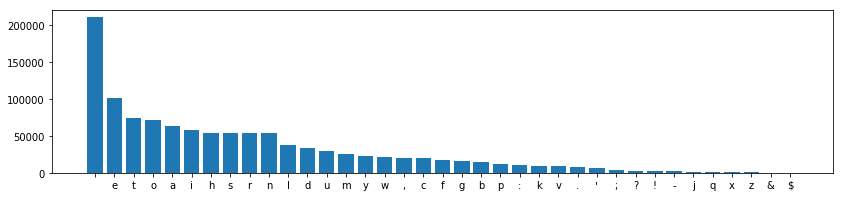

In [8]:
from collections import Counter

counter = Counter(text)
chars, counts = zip(*counter.most_common())
indices = np.arange(len(counts))

plt.figure(figsize=(14, 3))
plt.bar(indices, counts, 0.8)
plt.xticks(indices, chars);

We cut the dataset in fake sentences of fixed length. This could be greatly improved by using a sequence tokenizer.

In [9]:
max_length = 40
step = 3


def make_sequences(text, max_length=max_length, step=step):
    sequences = []
    next_chars = []
    for i in range(0, len(text) - max_length, step):
        sequences.append(text[i: i + max_length])
        next_chars.append(text[i + max_length])
    return sequences, next_chars    


sequences, next_chars = make_sequences(train_text)
sequences_test, next_chars_test = make_sequences(test_text, step=10)

num_sequences = len(sequences)
print('nb train sequences:', num_sequences)
print('nb test sequences:', len(sequences_test))

nb train sequences: 334597
nb test sequences: 11150


In [10]:
from sklearn.utils import shuffle

sequences, next_chars = shuffle(sequences, next_chars,
                                random_state=42)

In [11]:
sequences[1]

"ragg'd progeny, thou shouldst not scape "

In [12]:
next_chars[1]

'm'

In [13]:
import torch
use_gpu = torch.cuda.is_available
def gpu(tensor, gpu=use_gpu):
    if gpu:
        return tensor.cuda()
    else:
        return tensor

Each sentence will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `char_to_indices`.

In [14]:
# Turn string into list of longs
def char_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = char_to_indices[string[c]]
    return gpu(tensor)

print(char_to_tensor('abcdef'))

tensor([11, 12, 13, 14, 15, 16], device='cuda:0')


## Measuring per-character perplexity

The NLP community measures the quality of probabilistic model using [perplexity](https://en.wikipedia.org/wiki/Perplexity).

In practice perplexity is just a base 2 exponentiation of the average negative log2 likelihoods:

$$perplexity_\theta = 2^{-\frac{1}{n} \sum_{i=1}^{n} log_2 (p_\theta(x_i))}$$

**Note**: here we define the **per-character perplexity** (because our model naturally makes per-character predictions). **It is more common to report per-word perplexity**. Note that this is not as easy to compute the per-world perplexity as we would need to tokenize the strings into a sequence of words and discard whitespace and punctuation character predictions. In practice the whitespace character is the most frequent character by far making our naive per-character perplexity lower than it should be if we ignored those.

**Exercise**: implement a Python function that computes the per-character perplexity with model predicted probabilities `y_pred` and `indice_true` for the ground truth.

In [15]:
def perplexity(indice_true, y_pred):
    """Compute the perplexity of model predictions.
    
    indice_true is ground truth: indice of character.
    y_pred is predicted likelihoods for each class.
    
    2 ** -mean(log2(p))
    """
    #
    # your CODE here
    #

In [16]:
indice_true = [1,2]

y_pred = torch.Tensor([[0.1, 0.9, 0.0],[0.1,0.2,0.7]])

perplexity(indice_true, y_pred)

1.2598816041129843

# Build the Model

This model is taken from PyTorch tutorial. It will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [17]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [18]:
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = gpu(RNN(n_characters, hidden_size, n_characters, n_layers))
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Test the network on the first sentence in the test set.

In [19]:
sequences_test[0]

'gremio: good morrow, neighbour baptista.'

torch.Size([40, 1])


(tensor([[ 0.1083,  0.1114,  0.1071, -0.0732, -0.2118, -0.0474,  0.0292,  0.0363,
           0.1222, -0.1419,  0.0524,  0.1270, -0.1002, -0.1856,  0.0808, -0.2566,
          -0.1205, -0.1808,  0.0370,  0.0575, -0.0189,  0.3111, -0.0011, -0.1940,
           0.1401,  0.0107, -0.0616, -0.1133, -0.0455,  0.0839, -0.0672,  0.1398,
           0.1174, -0.1363, -0.2937, -0.3613,  0.2529]],
        device='cuda:0', grad_fn=<ThAddmmBackward>),
 tensor([[[ 0.0135, -0.2500,  0.1071,  0.0698,  0.0703, -0.0331,  0.1751,
            0.3541, -0.2664, -0.3061,  0.1968,  0.0157, -0.0211, -0.3073,
           -0.2975, -0.6584, -0.2380,  0.1359,  0.0153, -0.0541,  0.0674,
           -0.2319, -0.2751,  0.2931, -0.1641, -0.2029, -0.3467,  0.3329,
           -0.3563, -0.5393,  0.0339,  0.0345, -0.1413, -0.4366, -0.1044,
            0.0103, -0.3574, -0.0400,  0.0318, -0.0649, -0.0880, -0.3485,
           -0.0491,  0.2123,  0.0846, -0.3381,  0.1759, -0.0963, -0.1125,
            0.0649, -0.1663, -0.3903,  0.039

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [21]:
def evaluate(prime_str='t', predict_len=100, temperature=0.8):
    hidden = gpu(decoder.init_hidden())
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = indices_to_char[top_i.item()]#all_characters[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

In [22]:
evaluate('wh',10)

'whatoe,tf,b&'

# Training

form PyTorch turorial

In [23]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [24]:
def train(inp, target):
    
    hidden = gpu(decoder.init_hidden())
    decoder.zero_grad()
    loss = 0
    
    for c in range(max_length-1):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / max_length

Exercise: write the training loop. There is a slight modification copmared to the PyTorch tutorial because we did split the dataset in train and test... compute the perplexity on the test set.

In [25]:
n_epochs = 1
print_every = 100
plot_every = 10
n_pass = 2000

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    #
    # your CODE here
    #

 4s (epoch: 1 4%) 2.4137]
wh hagthe, lar ed thomepeind be prbrove bond bitin hy ot bort ken heard athe and alnd teer;  pite hous  

 8s (epoch: 1 9%) 2.3177]
wh anere suce where there or i have ar therer.  at shat manots gour: of ay ther owe withe padle's thear 

 13s (epoch: 1 14%) 2.1824]
wh son dee min the sit ar, a mand and and thi so and wourl; the sed lever ploving and not mope and any  

 17s (epoch: 1 19%) 2.0682]
wh dussphio: of haene the wil dom digh the mave is heaw bot hit suck hougk than restw is fat and way, f 

 21s (epoch: 1 24%) 2.1304]
wh the wheriom dove the of dort dearung faver, hivere deard there thes fall; i hik: wit writ thing.  od 

 26s (epoch: 1 29%) 1.9171]
wh all of i wran, i have duege youd; coushill an a known posdes rom: avere the that the a haust you sli 

 30s (epoch: 1 34%) 1.8630]
wh the and ye whestere carenintal, wher to mre your foor omors: and your carce thist ond shon as the da 

 34s (epoch: 1 39%) 1.7078]
wh time, this hath bet cangoure sight 

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

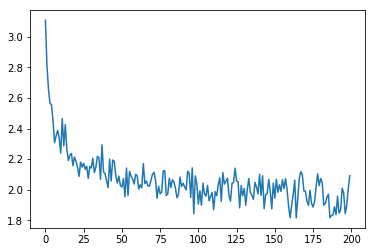

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [27]:
print(evaluate('th', 200, temperature=0.8))

th you good plath, t art the thour oft thno graiie, in and the thour muth my hearveth; with qure and of shade. ear.  merath; ponce in the hand am art pont; me, and to me ome so me comes grear fome would


Lower temperatures are less varied, choosing only the more probable outputs:

In [28]:
print(evaluate('th', 200, temperature=0.2))

ther fare the pother for the preath are to me to me to maine the preath him. i manders.  pring me some me to me of to me to me to me to me as the preath.  preart: are the preath are the preare and the h


Higher temperatures more varied, choosing less probable outputs:

In [29]:
print(evaluate('th', 200, temperature=1.4))

thut. grie vank, you he asrets some quang! su, ixeseer? 'mynust! to maon pimig--horque a! ee, uto 'kinghild obry o'd arwelf gahesed! eard.? frth uncar: coldef viuth'd pom proead thom pry. liodintw loant


# Exercise

Modify the code to use batches of sentences and remove the for loop in the  function `train`

## Why build a language model?

Building a language model is not very useful by it-self. However language models have recently been shown to be useful for **transfer learning** to build **contextualized word embeddings** as a better alternative to word2vec or GloVe.

Using language-model based word representations makes it possible to reach the **state-of-the-art at many natural language understanding problems**.

The workflow is the following:

- **train** a (bi-directional) **deep language model on a very large, unlabeled corpus** (e.g. 1 billion words or more);
- plug the resulting **language model as the input layer** (and sometimes also the output layer) **of a task specific architecture**, for instance: text classification, semantic role labeling for knowledge extraction, logical entailment, question answering and reading comprehension;
- **train the task specific parameters** of the new architecture on the **smaller task-labeled corpus**;
- optionally fine-tune the full architecture on the task-labeled corpus if it's big enough not to overfit.

More information on this approach:

- Deep contextualized word representations, https://arxiv.org/abs/1802.05365
- [Pytorch implementation of ELMo](https://github.com/allenai/allennlp/blob/master/allennlp/modules/elmo.py) as part of the AllenNLP project: https://github.com/allenai/allennlp
- Universal Language Model Fine-tuning for Text Classification: https://arxiv.org/abs/1801.06146 (ULMFiT)